In [1]:
import os
import PIL
import cv2
import scipy
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import tqdm as notebook_tqdm
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder

## Dataset
The textile fabric database consists of 245 images of 7 different fabrics. There are 140 defect-free images, 20 for each type of fabric. With different types of defects, there are 105 images.

Images have a size of 4096×256 pixels. Defective images have been denominated as follows: nnnn_ddd_ff.png, where nnnn is the image number, ddd is the defect code, and ff is the fabric code.

In [44]:
dataset_folder = "../archive"  
no_defect_images_folder = os.path.join(dataset_folder, "NODefect_images")
defect_images_folder = os.path.join(dataset_folder, "Defect_images")
mask_images_folder = os.path.join(dataset_folder, "Mask_images")

def gather_filenames(mypath: os.path) -> list[str]:
    filepaths = []
    for path, _, files in os.walk(mypath):
        for name in files:
            filepaths.append(os.path.join(path, name))
    return filepaths

defect_file_paths = gather_filenames(defect_images_folder)
no_defect_file_paths = gather_filenames(no_defect_images_folder)

print(f'Defects found: {len(defect_file_paths)}\nNo Defects found: {len(no_defect_file_paths)}')


Defects found: 106
No Defects found: 141


In [54]:
# Defect codes
DEFECT_CODES = {
    0:  'No defect',
    2:	'Broken end',
    6:	'Broken yarn',
    10:	'Broken pick',
    #16:	'Weft curling',
    #19:	'Fuzzyball',
    22:  'Cut selvage',
    23:  'Crease',
    25:	'Warp ball',
    #27:  'Knots',
    #29:  'Contamination',
    #30:  'Nep',
    #36:  'Weft crack'
}
output_len = len(DEFECT_CODES)

#encode defects to 0-12
DEFECT_ENCODINGS = {}
for i, key in zip(range(len(DEFECT_CODES)) , DEFECT_CODES.keys()):
    DEFECT_ENCODINGS[key] = i

def extract_labels(filepaths: list[str]) -> pd.DataFrame:
    image_df = pd.DataFrame(filepaths, columns=['filepath'])

    # x.split('\\') willl give the filename, then x.split('_') will give the labels
    image_df['id'] = image_df['filepath'].map(lambda x: int(x.split('\\')[-1].split('_')[0]))
    image_df['defect'] = image_df['filepath'].map(lambda x: int(x.split('\\')[-1].split('_')[1]))
    image_df['fabric'] = image_df['filepath'].map(lambda x: int(x.split('\\')[-1].split('_')[2].split('.')[0]))
    return image_df

In [59]:
# Files names to image dataset
defect_image_df = extract_labels(defect_file_paths)

# drop unwanted labels
defect_image_df = defect_image_df.drop(defect_image_df[defect_image_df['defect'] == 16].index)
defect_image_df = defect_image_df.drop(defect_image_df[defect_image_df['defect'] == 19].index)
defect_image_df = defect_image_df.drop(defect_image_df[defect_image_df['defect'] == 27].index)
defect_image_df = defect_image_df.drop(defect_image_df[defect_image_df['defect'] == 29].index)
defect_image_df = defect_image_df.drop(defect_image_df[defect_image_df['defect'] == 30].index)
defect_image_df = defect_image_df.drop(defect_image_df[defect_image_df['defect'] == 36].index)

# down sample
no_defect_image_df = extract_labels(no_defect_file_paths)
no_defect_image_df = no_defect_image_df.sample(n=80, random_state=1)



In [60]:
# Select Defects to encode
defect_image_df['defect'] = defect_image_df['defect'].map(lambda x: DEFECT_ENCODINGS[x])
no_defect_image_df['defect'] = no_defect_image_df['defect'].map(lambda x: DEFECT_ENCODINGS[x])

# combine all images for training and testing
full_image_df = pd.concat([defect_image_df, no_defect_image_df])


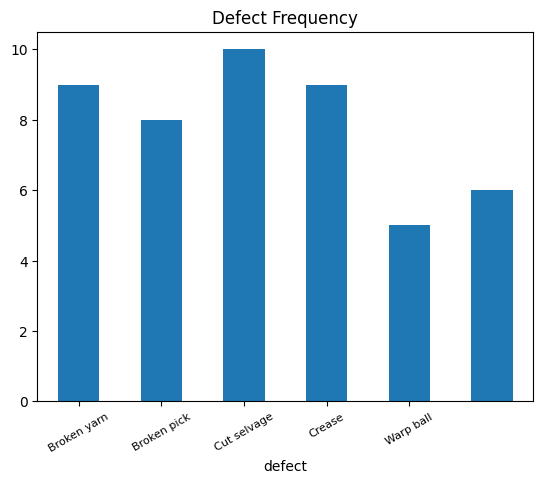

In [61]:
ax = defect_image_df['defect'].value_counts().sort_index().plot(kind = 'bar', title='Defect Frequency')
plt.xticks(range(0,len(DEFECT_CODES) - 1), list(DEFECT_CODES.values())[1:])
ax.xaxis.set_tick_params(rotation=30, labelsize=8)
plt.gca().spines[['top', 'right',]].set_visible(True)

In [62]:
def one_encode_defect(df: pd.DataFrame):
    # one hot the encoding
    enc = OneHotEncoder()
    enc.fit([[i] for i in df['defect']])
    return enc.transform([[i] for i in df['defect']]).toarray()

def preprocess_img(file_path: tf.Tensor, label: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
    img = tf.io.read_file(file_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.resize(img, [224, 224])      # resize because resnet input is 224x224
    img = tf.image.grayscale_to_rgb(img)
    img -= tf.reduce_mean(img, axis=0)
    img = img / 255.0 #
    return img, label


# Files names to image dataset
x_files = full_image_df['filepath'].to_numpy()
y_labels = one_encode_defect(full_image_df)

file_ds = tf.data.Dataset.from_tensor_slices((x_files, y_labels))
image_ds = file_ds.map(preprocess_img)

In [63]:
# shuffle
ds_size = len(image_ds)
image_ds = image_ds.shuffle(ds_size, seed =2)

# split
train_split = 0.75
train_size = int(train_split * ds_size)

val_split = 0.15
val_size = int(val_split * ds_size)

test_split = 0.10

train_ds = image_ds.take(train_size)    
val_ds = image_ds.skip(train_size).take(val_size)
test_ds = image_ds.skip(train_size).skip(val_size)

# len(train_ds) = 185
train_ds = train_ds.batch(5)
val_ds = val_ds.batch(5)
test_ds = test_ds.batch(5)

## Supervised Learning

In [65]:
# Transfer learning on the top layers
# Load convolutional weights that are trained on ImageNet data

base_model = tf.keras.applications.resnet.ResNet152(
    weights = 'imagenet', 
    include_top = False, 
    input_shape = (224, 224, 3)
)

# Freeze pretrained layers
for layer in base_model.layers:
  layer.trainable = False

x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(1000, activation='relu')(x)
predictions = tf.keras.layers.Dense(output_len, activation = 'softmax')(x)
head_model = tf.keras.Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer='adam', loss= tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [66]:
history = head_model.fit(train_ds, epochs= 5, validation_data= val_ds)

Epoch 1/5
7/7 [==============================] - 29s 3s/step - loss: 45.2630 - accuracy: 0.0857 - val_loss: 39.3220 - val_accuracy: 0.1429
Epoch 2/5
7/7 [==============================] - 11s 2s/step - loss: 29.5242 - accuracy: 0.2000 - val_loss: 16.0754 - val_accuracy: 0.1429
Epoch 3/5
7/7 [==============================] - 12s 2s/step - loss: 8.9581 - accuracy: 0.0571 - val_loss: 2.7123 - val_accuracy: 0.2857
Epoch 4/5
7/7 [==============================] - 11s 2s/step - loss: 3.2933 - accuracy: 0.1714 - val_loss: 2.3490 - val_accuracy: 0.1429
Epoch 5/5
7/7 [==============================] - 12s 2s/step - loss: 1.9201 - accuracy: 0.2857 - val_loss: 1.9568 - val_accuracy: 0.2857


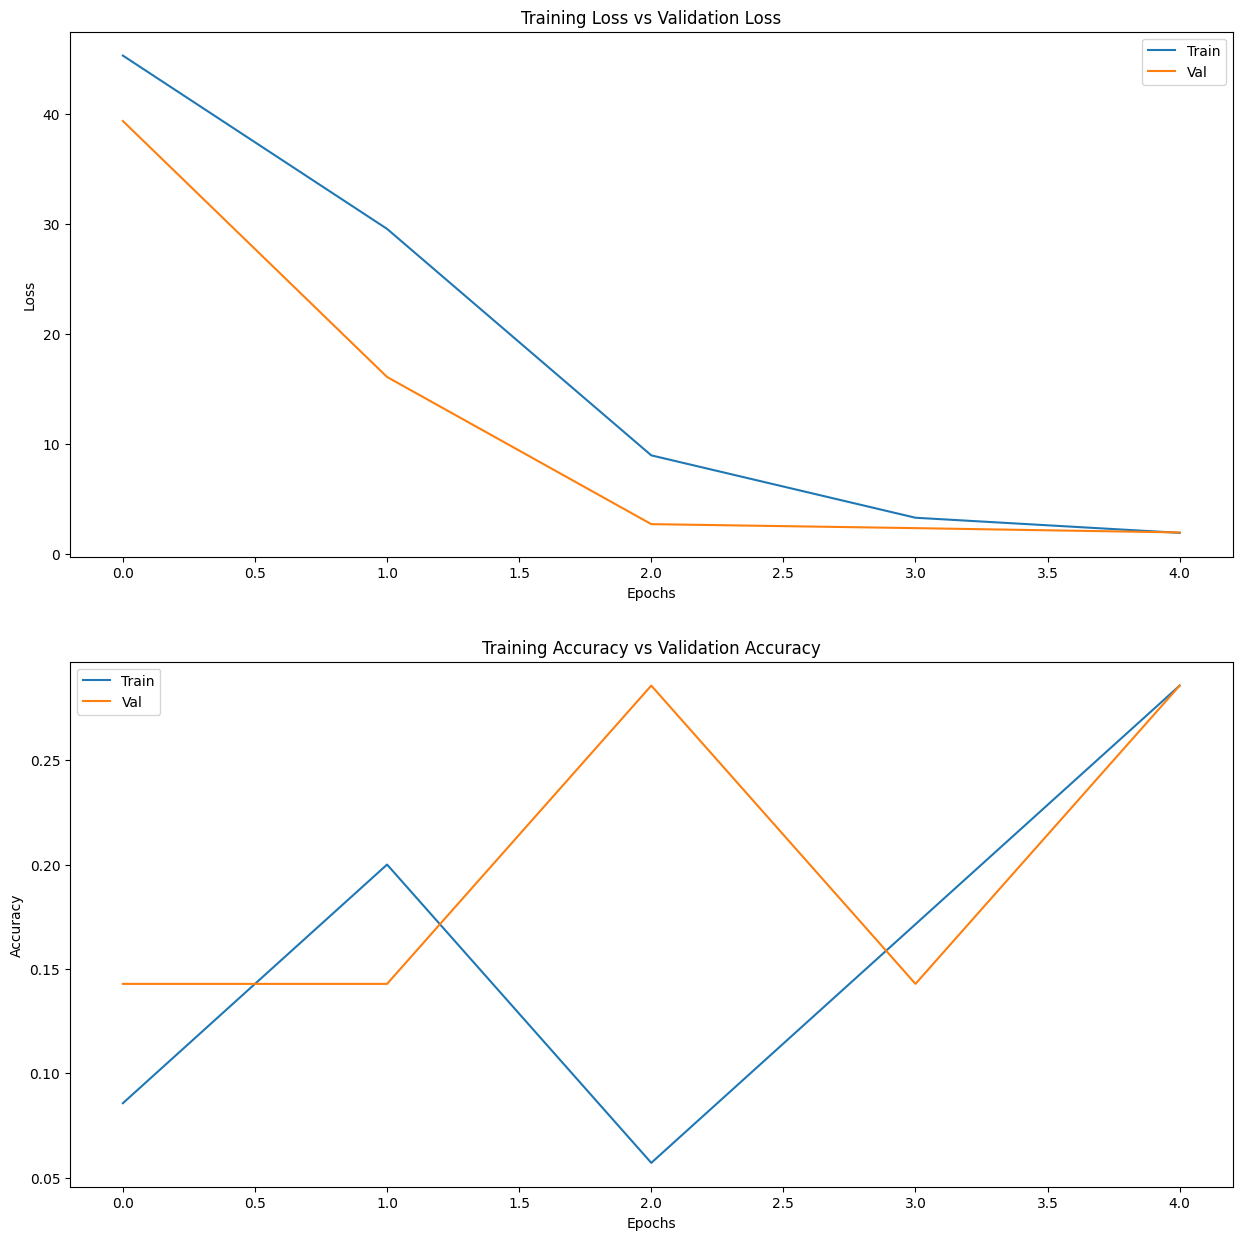

In [67]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [33]:
head_model.evaluate(test_ds, verbose=2)

3/3 - 3s - loss: 0.7718 - accuracy: 0.8462 - 3s/epoch - 913ms/step


[0.7717649936676025, 0.8461538553237915]

In [38]:
metric = tf.keras.metrics.F1Score()

test_y_true_ds = [label.numpy() for _, label in test_ds.unbatch()]
test_y_true_ds = np.array(test_y_true_ds)
test_y_pred_ds = head_model.predict(test_ds, verbose=2)




3/3 - 3s - 3s/epoch - 924ms/step


In [39]:
metric.update_state(test_y_true_ds, test_y_pred_ds)
result = metric.result()
result.numpy()

array([0.8695652, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       ], dtype=float32)

In [40]:
true_labels = np.array([np.argmax(label) for label in test_y_true_ds])
pred_labels = np.array([np.argmax(label) for label in test_y_pred_ds])


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [41]:
tf.math.confusion_matrix(true_labels, pred_labels)

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[10,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0]])>

Model Deployment/Evaluation

Unsupervised or Semisupervised Learning